## Real Stock Portfolio Optimization (VQE - Fractional Ansatz)

This example notebook uses a **Variational Quantum Eigensolver (VQE)** with a **fractional ansatz** to optimize a portfolio of real stocks (AAPL, MSFT, GOOGL, AMZN).

### Key Highlights:

- **Live data** from Yahoo Finance (`yfinance`)
- **Fractional weights** encoded via RY rotations:  
  $w_i = \sin^2(θ_i / 2)$
- **Cost function** balances return, risk, and budget constraint:
  $\text{Cost} = -μ^T w + q \cdot w^T Σ w + \text{penalty}$
- **Outputs**: Final weights, convergence plot, bar and pie charts.

This example shows how quantum circuits can solve real-world finance problems using hybrid quantum-classical methods.

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import sys
repo_root = Path(__file__).resolve().parents[2] if "__file__" in globals() else Path.cwd().parents[1]
sys.path.insert(0, str(repo_root))
from Real_Stock_Data import get_stock_data

np.random.seed(0)

/usr/local/python/3.12.1/lib/python3.12/site-packages/pennylane/math/interface_utils.py:136: UserWarning: Contains tensors of types {'autograd', 'pandas'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


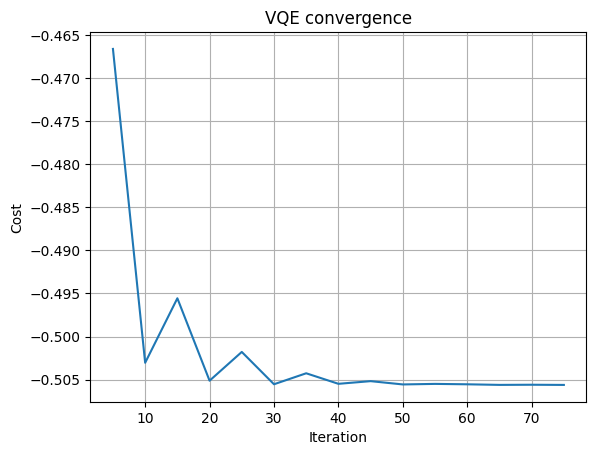

In [ ]:
# Problem setup
q = 0.5  # Risk aversion parameter
tickers = ["AAPL","MSFT","GOOGL","AMZN"]
mu, Sigma, prices = get_stock_data(tickers, start="2023-01-01", end="2024-01-01")
n = len(tickers)

# Quantum device and QNode
dev = qml.device("default.qubit", wires=n, shots=None)

@qml.qnode(dev, interface="autograd")
def qnode(thetas):
    # Hardware-efficient R_Y rotations (one per asset)
    for i in range(n):
        qml.RY(thetas[i], wires=i)

    # Return ⟨Z⟩ for each qubit
    return [qml.expval(qml.PauliZ(i)) for i in range(n)]

def angles_to_weights(thetas):
    # Map ⟨Z⟩ → fractional weights w_i = (1−⟨Z_i⟩)/2 and normalize
    z = qml.math.stack(qnode(thetas))
    w = (1.0 - z) * 0.5
    s = qml.math.sum(w)
    return w / (s + 1e-12)

def scaled_penalty(mu, Sigma):
    # Scale penalties to objective magnitude
    base = max(float(np.sum(np.abs(mu))), float(np.trace(Sigma)), 1e-3)
    return 50.0 * base

def objective(thetas):
    w = angles_to_weights(thetas)
    ret = qml.math.dot(mu, w)
    risk = qml.math.dot(w, qml.math.dot(Sigma, w))
    p_sum = scaled_penalty(mu, Sigma)
    c_sum = p_sum * (qml.math.sum(w) - 1.0) ** 2  # Budget Σw=1
    return -(ret) + q * risk + c_sum

# Optimize
thetas = np.array(np.random.uniform(0, np.pi, n), requires_grad=True)
opt = qml.AdamOptimizer(stepsize=0.3)
steps = 75
hist = []

for t in range(steps):
    thetas, cost = opt.step_and_cost(objective, thetas)
    if (t+1) % 5 == 0:
        hist.append(float(cost))

w_opt = angles_to_weights(thetas)
w_opt = w_opt / (np.sum(w_opt) + 1e-12)

# Convergence plot
plt.figure()
plt.plot(range(5, steps+1, 5), hist)
plt.xlabel("Iteration"); plt.ylabel("Cost"); plt.title("VQE convergence"); plt.grid(True)
plt.savefig("../images/Fractional_Example_Convergence.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Results
print("Optimized weights:")
for t, w in zip(tickers, w_opt):
    print(f"{t}: {float(w)*100:.2f}%")

Optimized weights:
AAPL: 0.00%
MSFT: 0.01%
GOOGL: 0.01%
AMZN: 99.98%


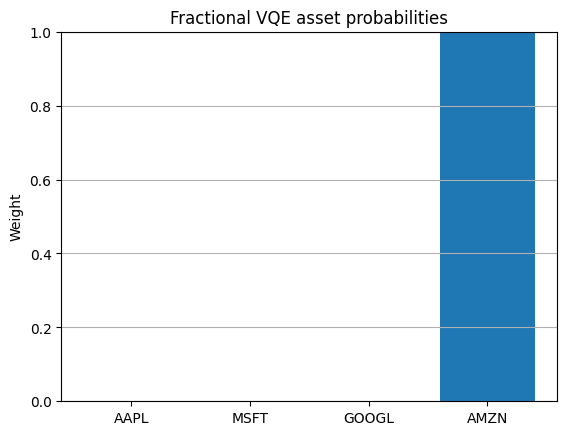

In [ ]:
# Bar plot
plt.figure()
plt.bar(tickers, w_opt)
plt.ylabel("Weight"); plt.ylim(0,1); plt.title("Fractional VQE asset probabilities"); plt.grid(axis="y")
plt.savefig("../images/Fractional_Example_Probabilities.png", dpi=300, bbox_inches="tight")
plt.show()

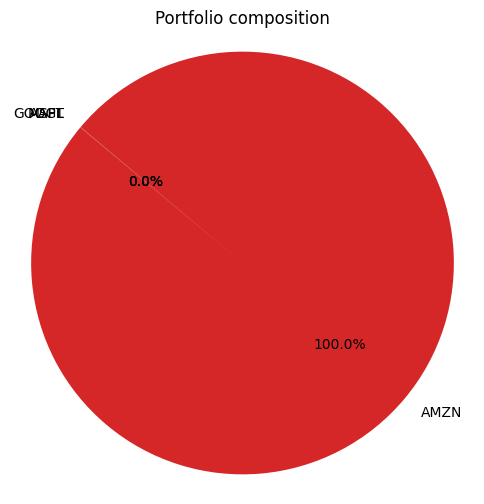

<Figure size 640x480 with 0 Axes>

In [ ]:
# Pie chart
plt.figure(figsize=(6,6))
plt.pie(w_opt, labels=tickers, autopct="%1.1f%%", startangle=140)
plt.title("Portfolio composition"); plt.axis("equal"); plt.show()
plt.savefig("../images/Fractional_Example_Pie.png", dpi=300, bbox_inches="tight")
plt.show()